In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,precision_score,recall_score,f1_score, precision_recall_curve
from sklearn import metrics
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Load data
df = pd.read_csv("pivoted_financial_data.csv")

# Create new features (example: growth rate for total income)
# Avoid division by zero
df["Income_Growth"] = np.where(df["Total income_1"] == 0, 0, 
                               (df["Total income_10"] - df["Total income_1"]) / df["Total income_1"])

df["Profit_Growth"] = np.where(df["Profit after tax_1"] == 0, 0, 
                               (df["Profit after tax_10"] - df["Profit after tax_1"]) / df["Profit after tax_1"])
df["Cash_Growth"] = np.where(df["Cash balance_1"] == 0, 0, 
                               (df["Cash balance_10"] - df["Cash balance_1"]) / df["Cash balance_1"])
df["PBDITA_Growth"] = np.where(df["PBDITA_1"] == 0, 0,
                               (df["PBDITA_10"] - df["PBDITA_1"]) / df["PBDITA_1"])
df["Long term loans & advances_Growth"] = np.where(df["Long term loans & advances_1"] == 0, 0,
                               (df["Long term loans & advances_10"] - df["Long term loans & advances_1"]) / df["Long term loans & advances_1"])
# Select key features for feature vector (example selection, adjust as needed)
features = [
    "Income_Growth", "Profit_Growth", "Cash_Growth", "PBDITA_Growth",
    "Current ratio (times)_1", "Current ratio (times)_10",
    "Change in total income_1","Change in total income_2",
    "Change in total income_3","Change in total income_4",
    "Change in total income_5","Change in total income_6",
    "Change in total income_7","Change in total income_8",
    "Change in total income_9","Change in total income_10",
    "Long term loans & advances_Growth"
]
X = df[features]
y = df["Label"]

# Split the dataset with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [3]:
def print_metrics(y_test,y_pred,clf):
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='macro')
    recall = recall_score(y_test,y_pred, average='macro')
    f1 = f1_score(y_test,y_pred, average='macro')
    print(f"For the {clf} Classifier: \n")
    print(f"Accuracy : {accuracy: .4f}")
    print(f"Precision : {precision : .4f}")
    print(f"Recall : {recall : .4f}")
    print(f"F1 Score : {f1 : .4f}")
    
    precision,recall,thresholds = precision_recall_curve(y_test,y_pred)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.plot(recall,precision,marker = '.', label = 'P-R Curve')
    plt.legend()
    plt.show()

In [4]:
def print_confusion_matrix(clf,y_test,y_pred):
    cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
    normalized_cnf_matrix = cnf_matrix.astype('float')/cnf_matrix.sum(axis = 1)[:,np.newaxis]
    # cnf_matrix
    plt.figure(figsize = (12,8))
    sns.heatmap(cnf_matrix, annot = True, fmt = '.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"The Confusion Matrix for the {clf} Classifier")
    plt.show()
    # normalized_cnf_matrix
    plt.figure(figsize = (12,8))
    sns.heatmap(normalized_cnf_matrix, annot = True, fmt = '.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"The Normalized Confusion Matrix for {clf} Classifier: ")

In [5]:
# Build a pipeline: scaling -> SMOTE -> classifier (RandomForest example)
pipeline_rf = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(sampling_strategy = 'minority', k_neighbors = 2, random_state = 42)),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning
param_grid_rf = {
    "classifier__n_estimators": [100, 200, 300, 500],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__class_weight": [None, "balanced"]
}

In [6]:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="f1", n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
print("Best Params (RF):", grid_search_rf.best_params_)

Best Params (RF): {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


For the Random Forest Classifier: 

Accuracy :  0.9584
Precision :  0.5804
Recall :  0.7122
F1 Score :  0.6129


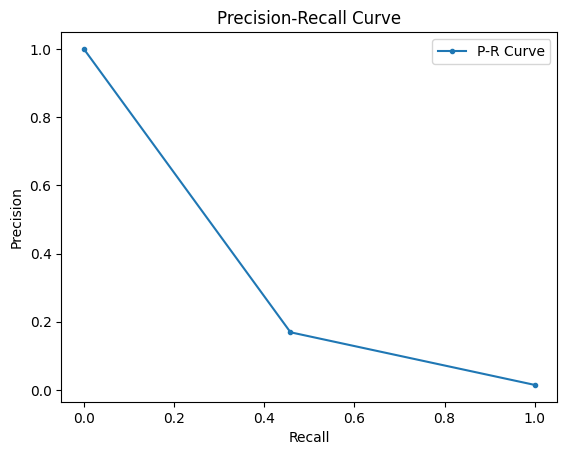

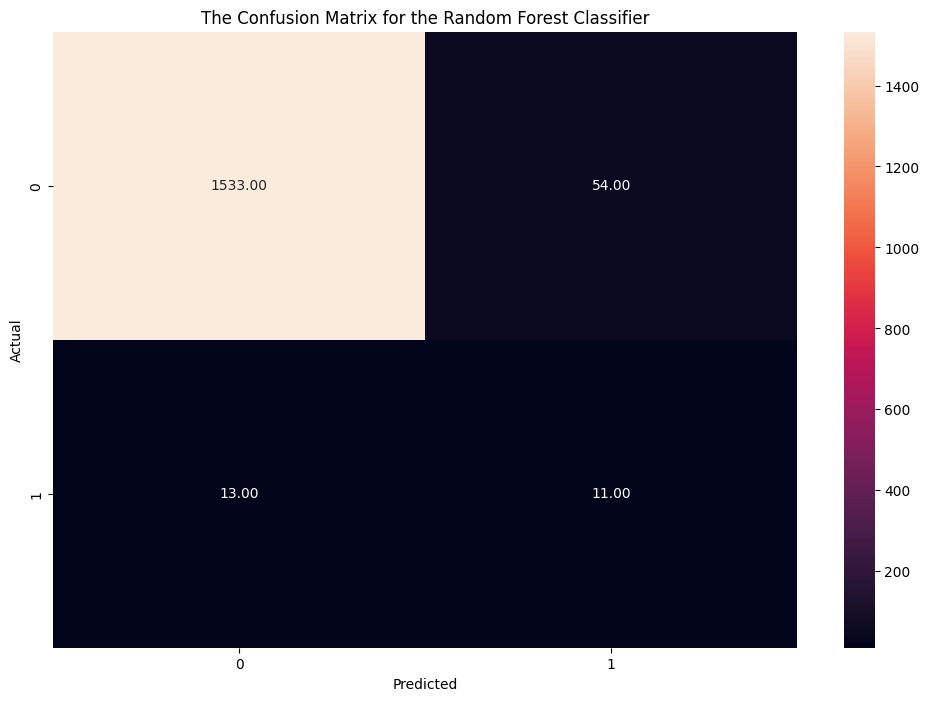

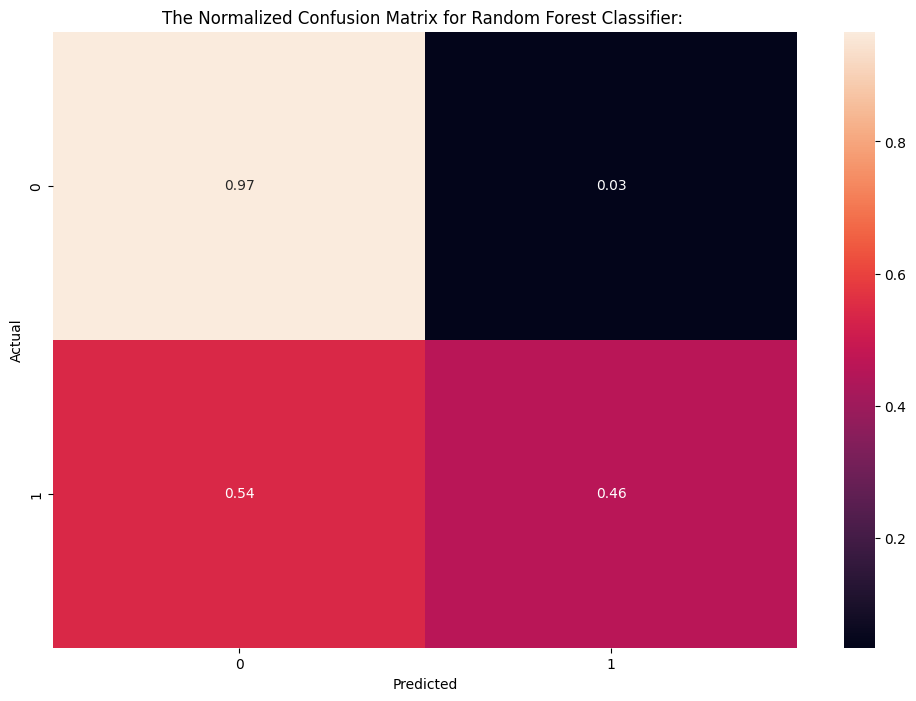

In [7]:
# Evaluate on test set
y_pred_rf = grid_search_rf.predict(X_test)
print_metrics(y_test,y_pred_rf, "Random Forest")
print_confusion_matrix("Random Forest",y_test,y_pred_rf)

In [8]:
pipeline_svm = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("classifier", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42))
])

param_grid_svm = {
    "classifier__C": [0.1, 1, 10],
    "classifier__gamma": [0.001, 0.01, 0.1]
}

In [9]:
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring="f1", n_jobs=-1)
grid_search_svm.fit(X_train, y_train)
print("Best Params (SVM):", grid_search_svm.best_params_)

Best Params (SVM): {'classifier__C': 0.1, 'classifier__gamma': 0.01}


For the SVM's Classifier: 

Accuracy :  0.1993
Precision :  0.5051
Recall :  0.5525
F1 Score :  0.1749


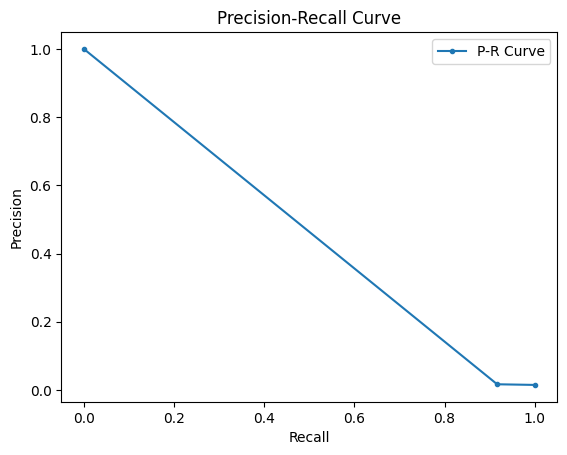

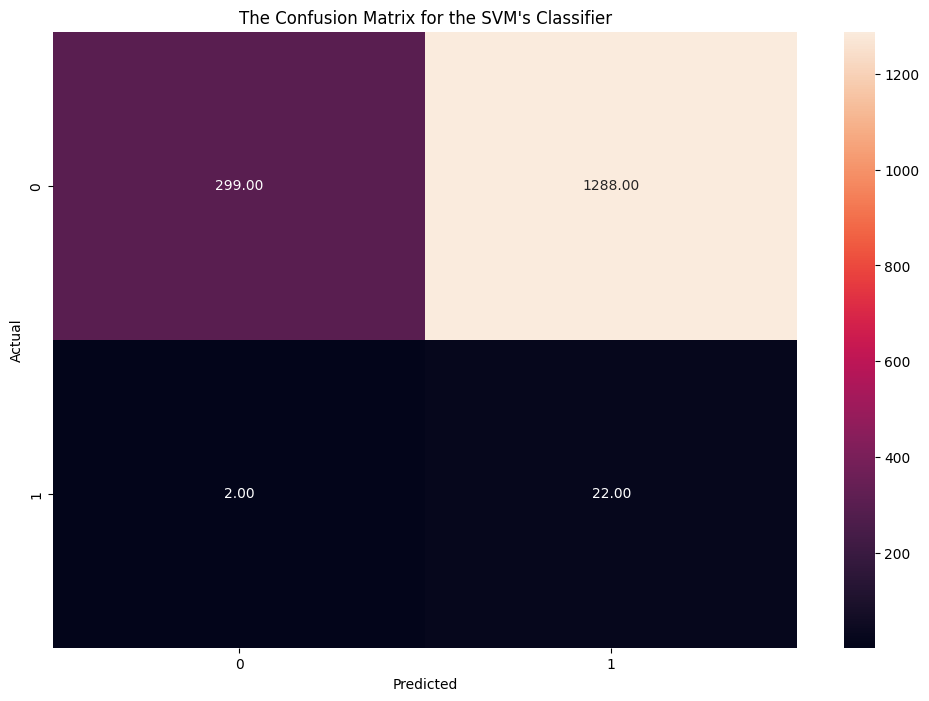

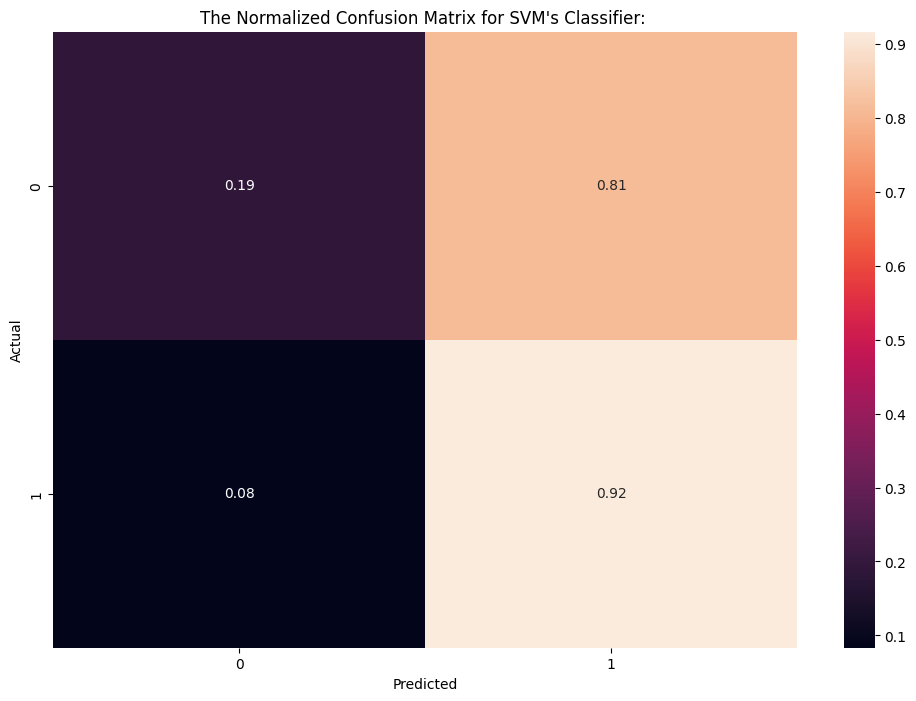

In [10]:
# Evaluate SVM
y_pred_svm = grid_search_svm.predict(X_test)
print_metrics(y_test,y_pred_svm, "SVM's")
print_confusion_matrix("SVM's",y_test,y_pred_svm)